<a href="https://colab.research.google.com/github/vikram2727/Drilling-Analysis/blob/main/Model_Script_ROP_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real time ROP prediction for offset wells

* __Authors__: Vikram Kumar
* __Date__: 4th may 2021


- <a>1. Introduction:  </a>
    - <a>1.1. Background</a>
    - <a>1.2. Problem Statement</a>
    - <a>1.3. Data Description</a>
    - <a>1.4. Evaluation Metric</a>
- <a>2. Imports Usefull Labraires</a>
- <a>3. Read in Data</a>
- <a>4. Data Visualization, Normalization, Clustering, Model Development.</a>
    - <a>4.1. Final Submission </a>
- <a>5. Summary</a>

<a></a>

#1.Introduction:Data Driven model for Real time ROP prediction for offset wells



### 1.1. Background
For conventional drilling Rate of Penetration (ROP) is most important factors influencing the drilling efficiency. As we know that the vendor charge rig cost and operation cost per day. However the maximum ROP can reduce the overall capital cost. The the new era of data science and computatinal technology we developed the data driven model is by utilizing the seven vertical wells to predict the real time ROP of offset wells real time operational parameters while drilling.

### 1.2. Problem Statement
Drilling cost consists of more than half of the budget of any exploration and developmental project.Therefore The approches of drilling industry is to reduce the Non Productive time like drilling problem including formation damage, bit bounce,reduces life expectancy of bit.

### 1.3.Data Description
Equinor  In Oct-Sept 2018 release volve dataset consist of approximately 40,000 files of   Exploration and Production which was in production from 2008 to 2016, The intension of disclosing of bulk datset is to Support learning  innovation and new solution and possibility to extend the life of field. For this project we use seven wells with twelve usefull and common drilling attributes with nearly 200,000 samples and one offset well or blind well.
 
1.The attributes include: -

1. Well Identifier: - ID for identifying a particular Well
2. Measured Depth, m: - The length of the wellbore, as if determined by a measuring stick.
3. Weight on Bit, kkgf: - Weight on the Bit, or WOB, is the amount of downward force exerted on the drill bit provided by thick-walled tubular pieces in the drilling assembly that are known as drill collars. The downward force of gravity on these steel tubes provide force for the drill bit in order to effectively break the rock.
4. Average Standpipe Pressure, kPa: - Standpipe pressure (SPP) is the total pressure loss in a system that occurs due to fluid friction.
5. Average Surface Torque, kNm: - Torque, is the rotational force between the drill string and the formation.
6. Rate of Penetration, m/h: - In the drilling industry, the rate of penetration (ROP), also known as penetration rate or drill rate, is the speed at which a drill bit breaks the rock under it to deepen the borehole. It is normally measured in feet per minute or meters per hour, but sometimes it is expressed in minutes per foot.
7. Average Rotary Speed, rpm: - Rotational speed of drill bit
8. Mud Flow, L/min: - The rate of mud flowing into the well during drilling.
9. Mud Density, g/cm3: - The mass per unit volume of a drilling fluid, synonymous with mud weight. Mud weight controls hydrostatic pressure in a wellbore and prevents unwanted flow into the well.
10. Diameter, mm: - Diameter refers to the nominal wellbore diameter.
11. Average Hookload, kkgf: - The total force pulling down on the hook. This total force includes the weight of the drillstring in air, the drill collars and any ancillary equipment, reduced by any force that tends to reduce that weight.
12. Hole Depth (TVD), m: - The vertical distance from a point in the well (usually the current or final depth) to a point at the surface.
13. USROP Gamma, gAPI.
Some processing has already been done by Tunkiel to preserve original data as mentioned below. This is necessary as the drilling logs often contain erroneous, nonphysical values.

Samples containing Weight on Bit values below 0 and above 35 were truncated.
The same way rows with Mud Density In, Mud Flow In, and Average Surface Torque values below zero were removed, as well as with Rate of Penetration values above 100 and Average Standpipe Pressure above 25,000.
Forward and backward filling was used to fill in the small gaps in the data resulting from uneven logging frequency of different equipment.
There was no unified gamma reading between all the wells, hence a new attribute, USROP Gamma, was introduced. It contains data logged under different names and different equipment, sometimes even within the same well.






### 1.4. Evaluation Metric
Mean Absolute Error(MAE) we know that an error basically is the absolute difference between the actual or true values and the values that are predicted. Absolute difference means that if the result has a negative sign is ignored.
Hence, MAE = True values – Predicted values

#2.Imports usefull labraires





In [1]:
# import libraries
import glob
import os
import pandas as pd
import numpy as np
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

# import Machine learning labraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# others libraries


# 3.Read data

In [2]:
#read train csv file using pandas train
train_df = pd.read_csv("/content/drive/MyDrive/prac data/tech_challenge2021_train.csv") # concate of all 7 wells
test_df  = pd.read_csv("/content/drive/MyDrive/prac data/tech_challenge2021_test.csv")  # blind or test well


# folder read drill_data and sorted all csv file in alphabetically ordered
paths = sorted(glob.glob(os.path.join('/content/drive/MyDrive/drill_data',"*.csv")))

well_df = [0]*7
for i in range(len(paths)):

  #read csv file with pandas to create dataframes of all seven wells are sepreated  
  well = pd.read_csv(paths[i])
  
  # in this dataframe, depth is positioned as index, not as column
  # so better to change depth index to column
  well_df[i] = well.reset_index()

well1, well2, well3, well4, well5 , well6, well7 = well_df  # here we have all seven well

In [3]:
well5.describe() ## well5 description

index    Unnamed: 0  ...  Hole Depth (TVD) m  USROP Gamma gAPI
count  51708.000000  51708.000000  ...        51708.000000      51708.000000
mean   25853.500000  25853.500000  ...         2484.777600         57.162113
std    14926.958196  14926.958196  ...          519.979329         49.610070
min        0.000000      0.000000  ...         1367.018856          0.000000
25%    12926.750000  12926.750000  ...         2055.263352         15.640000
50%    25853.500000  25853.500000  ...         2652.019994         42.161000
75%    38780.250000  38780.250000  ...         2900.238446         90.350000
max    51707.000000  51707.000000  ...         3171.808846        255.462000

[8 rows x 14 columns]

In [4]:
# training data set head
train_df.head(5)    ## train_df contain all 7 well concated

Well Identifier  ...  USROP Gamma gAPI
0  USROP_A 0 N-NA_F-9_Ad  ...            150.88
1  USROP_A 0 N-NA_F-9_Ad  ...            150.88
2  USROP_A 0 N-NA_F-9_Ad  ...            150.88
3  USROP_A 0 N-NA_F-9_Ad  ...            146.26
4  USROP_A 0 N-NA_F-9_Ad  ...            146.26

[5 rows x 13 columns]

In [5]:
train_df.describe()
# Just look at the dataset 
# we can observe coefficient of variation(STD/MEAN) is less as expected from given dataset.


Measured Depth m  ...  USROP Gamma gAPI
count     198928.000000  ...     198928.000000
mean        2411.781370  ...         67.197939
std         1066.443448  ...         50.519888
min          225.171000  ...          0.000000
25%         1548.686750  ...         25.380000
50%         2697.182500  ...         54.490000
75%         3288.946500  ...         98.140000
max         4090.001000  ...        260.899000

[8 rows x 12 columns]

In [6]:
## Name of all 7 wells 
wellnames = train_df['Well Identifier'].unique()
wellnames

array(['USROP_A 0 N-NA_F-9_Ad', 'USROP_A 1 N-S_F-7d',
       'USROP_A 2 N-SH_F-14d', 'USROP_A 3 N-SH-F-15d',
       'USROP_A 4 N-SH_F-15Sd', 'USROP_A 5 N-SH-F-5d',
       'USROP_A 6 N-SH_F-9d'], dtype=object)

# 4.Data Visualization, Normalization, Clustering, Model Development.

In [7]:
train_df.isnull().sum()  ## we dont have any NAN values and expected clean data as mention in data description.

Well Identifier                   0
Measured Depth m                  0
Weight on Bit kkgf                0
Average Standpipe Pressure kPa    0
Average Surface Torque kN.m       0
Rate of Penetration m/h           0
Average Rotary Speed rpm          0
Mud Flow In L/min                 0
Mud Density In g/cm3              0
Diameter mm                       0
Average Hookload kkgf             0
Hole Depth (TVD) m                0
USROP Gamma gAPI                  0
dtype: int64

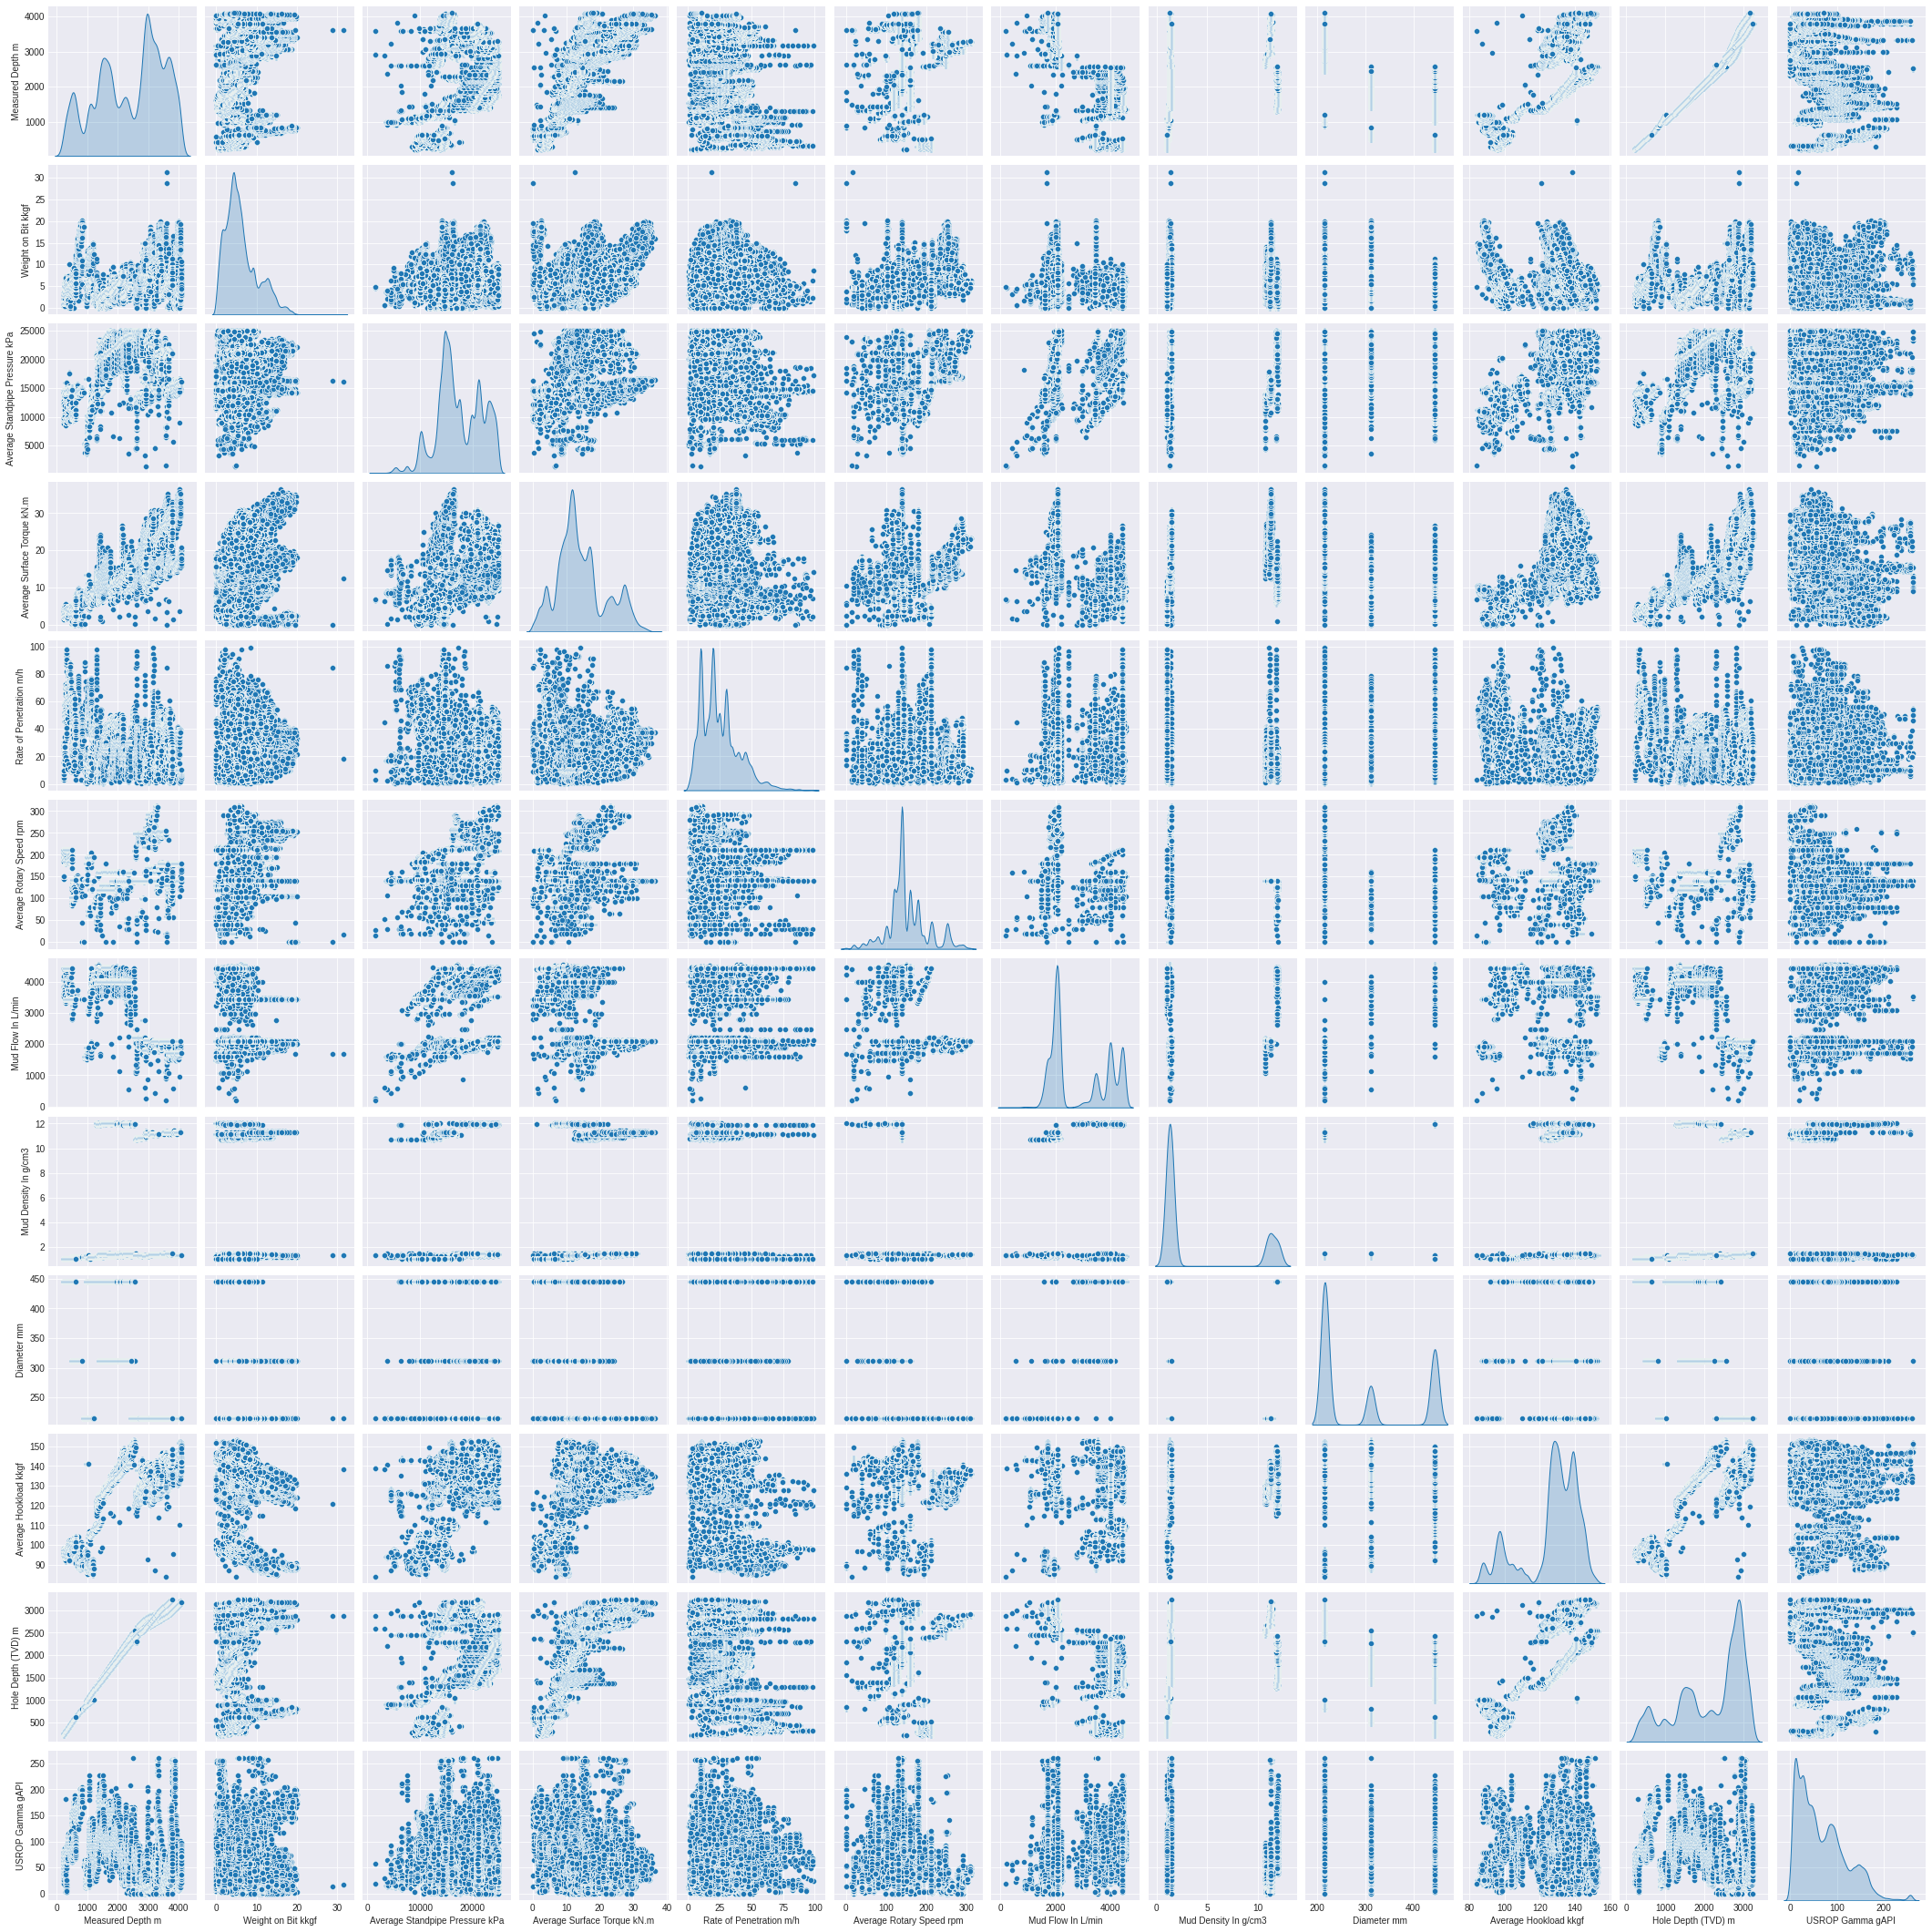

In [8]:
## Pair_plot to see the realations among diffrent attributes.
## We can Distribution of data in diagonal plot are not normal distrinution or gaussian
sns.pairplot(train_df , diag_kind='kde')


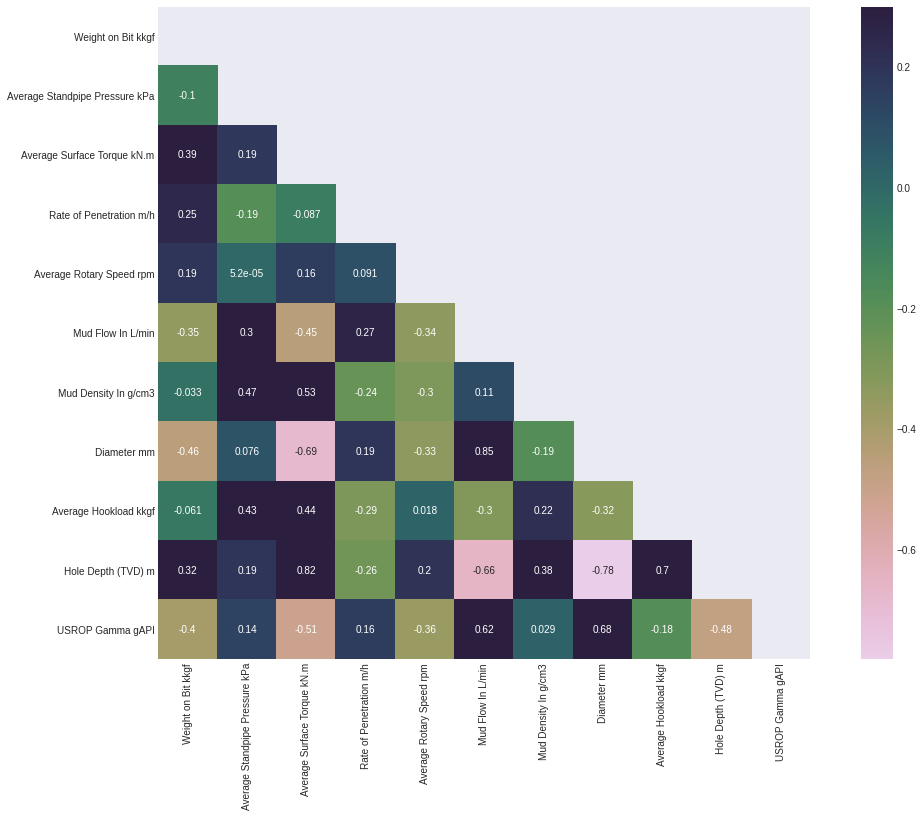

In [9]:
##	Spearman relation  correlation coefficient in heatmap
data_column = ['Weight on Bit kkgf',  'Average Standpipe Pressure kPa',	'Average Surface Torque kN.m',
               'Rate of Penetration m/h',	'Average Rotary Speed rpm',	'Mud Flow In L/min',	
               'Mud Density In g/cm3',	'Diameter mm',	'Average Hookload kkgf',	'Hole Depth (TVD) m',	
               'USROP Gamma gAPI']

well_train = train_df[data_column]

# Generate a mask for the upper triangle
mask = np.zeros_like(well_train.corr(method = 'spearman') , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(18,12))
sns.heatmap(well_train.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap, vmax=.3, square=True)

plt.show()

In [10]:
## Normalization of train_df to obtain normal distribution except hole depth(TVD)

train_col = ['Well Identifier','Hole Depth (TVD) m','Measured Depth m','Weight on Bit kkgf','Average Standpipe Pressure kPa',	
           'Average Surface Torque kN.m','Average Rotary Speed rpm',	'Mud Flow In L/min',	
           'Mud Density In g/cm3',	'Diameter mm',	'Average Hookload kkgf'	,'USROP Gamma gAPI','Rate of Penetration m/h']

feature = ['Measured Depth m','Weight on Bit kkgf', 'Average Standpipe Pressure kPa',	
           'Average Surface Torque kN.m','Average Rotary Speed rpm',	'Mud Flow In L/min',	
           'Mud Density In g/cm3',	'Diameter mm',	'Average Hookload kkgf'	,'USROP Gamma gAPI']


target  = 'Rate of Penetration m/h'

feature_target = np.append(feature,target) # feature and target column names

feature_target

array(['Measured Depth m', 'Weight on Bit kkgf',
       'Average Standpipe Pressure kPa', 'Average Surface Torque kN.m',
       'Average Rotary Speed rpm', 'Mud Flow In L/min',
       'Mud Density In g/cm3', 'Diameter mm', 'Average Hookload kkgf',
       'USROP Gamma gAPI', 'Rate of Penetration m/h'], dtype='<U30')

In [11]:
well_train_drop = train_df.drop(['Hole Depth (TVD) m','Well Identifier'], axis=1)
well_train = well_train_drop
colnames = well_train_drop.columns

well_test_drop = test_df.drop(['Hole Depth (TVD) m','Well Identifier'],axis = 1)
colnames

Index(['Measured Depth m', 'Weight on Bit kkgf',
       'Average Standpipe Pressure kPa', 'Average Surface Torque kN.m',
       'Rate of Penetration m/h', 'Average Rotary Speed rpm',
       'Mud Flow In L/min', 'Mud Density In g/cm3', 'Diameter mm',
       'Average Hookload kkgf', 'USROP Gamma gAPI'],
      dtype='object')

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

# normalize using power transform Yeo-Johnson method.
scaler = PowerTransformer(method='yeo-johnson')

## ColumnTransformer
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

## fit and transform
well_train_norm = ct.fit_transform(well_train)

## convert to dataframe
well_train_norm = pd.DataFrame(well_train_norm, columns=feature_target)

## add 'Hole Depth (TVD) to well_train_norm
x = well_train_norm[feature_target].astype(float)
z = train_df['Hole Depth (TVD) m'].astype(float)
well_train_norm = pd.concat([x,z], axis=1)
well_train_norm

Measured Depth m  ...  Hole Depth (TVD) m
0              -1.764998  ...          490.760309
1              -1.764870  ...          490.910880
2              -1.764839  ...          490.910880
3              -1.764741  ...          491.061756
4              -1.764738  ...          491.061756
...                  ...  ...                 ...
198923         -1.643474  ...          633.068076
198924         -1.643434  ...          633.208589
198925         -1.643384  ...          633.266196
198926         -1.643342  ...          633.219562
198927         -1.643334  ...          633.323803

[198928 rows x 12 columns]

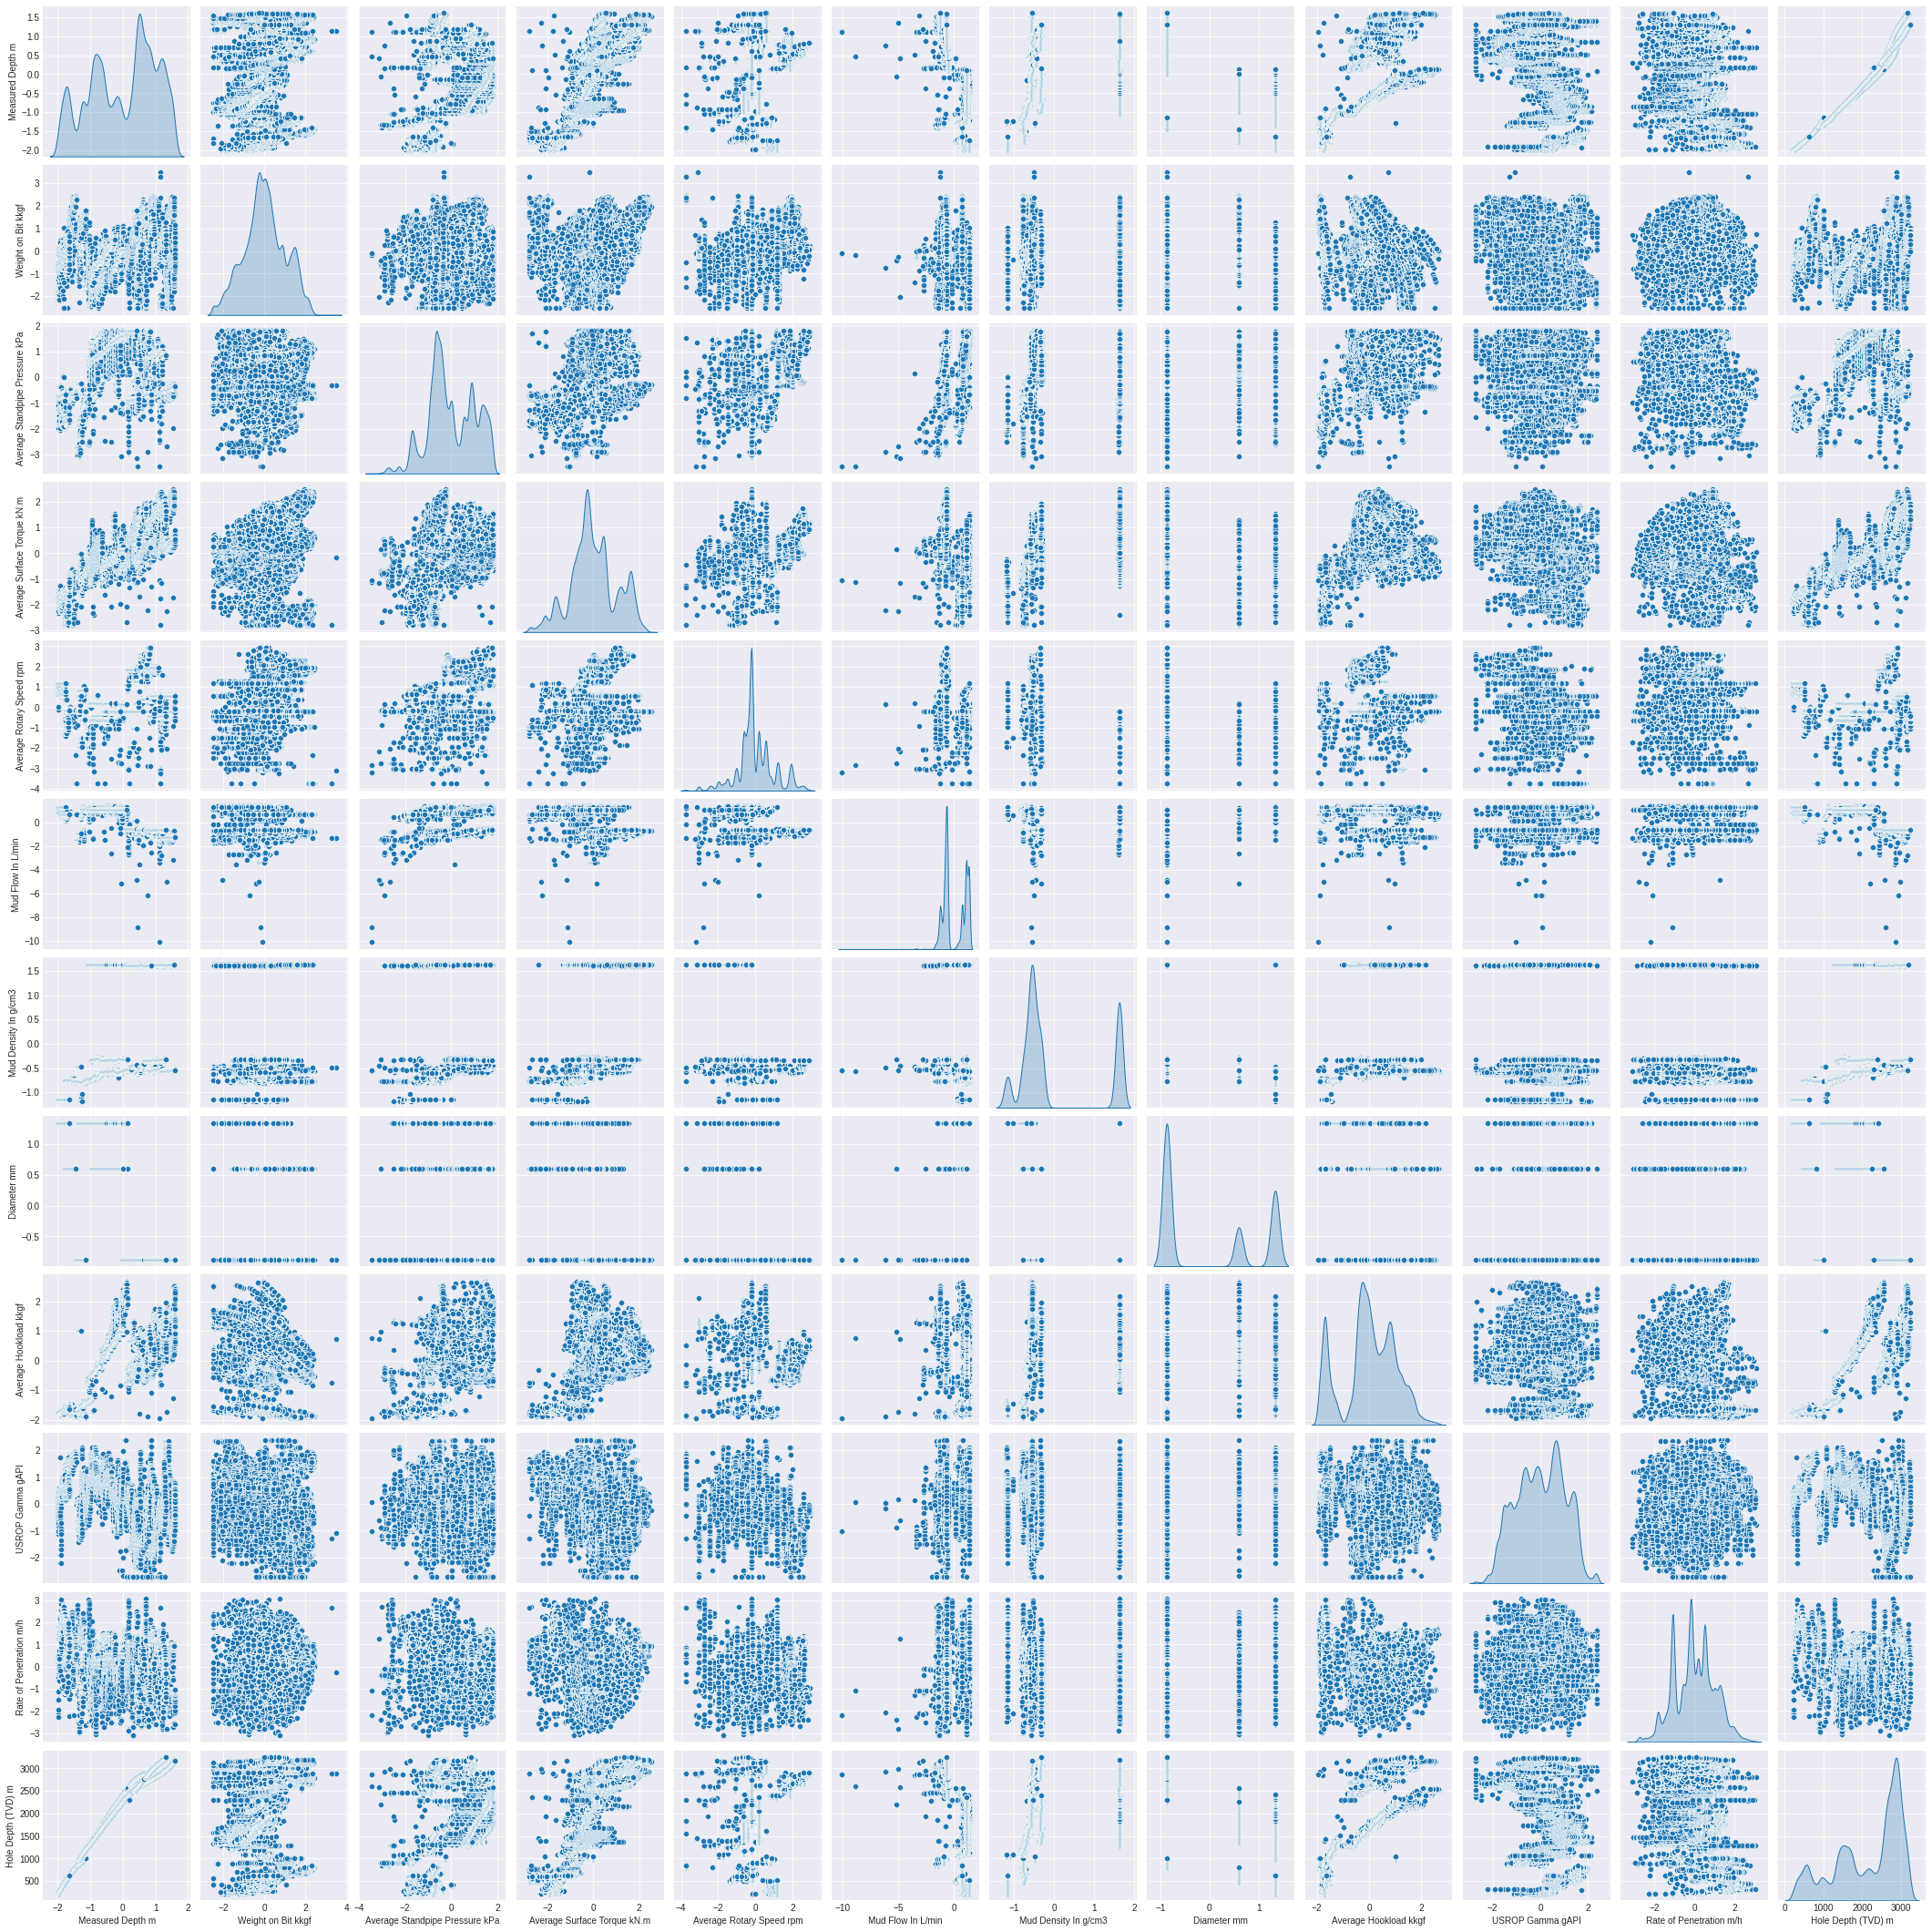

In [13]:
sns.pairplot(well_train_norm , diag_kind='kde')
#sns.pairplot(train_df[train_df['Well Identifier']==wellnames[0]],diag_kind='kde')

No handles with labels found to put in legend.


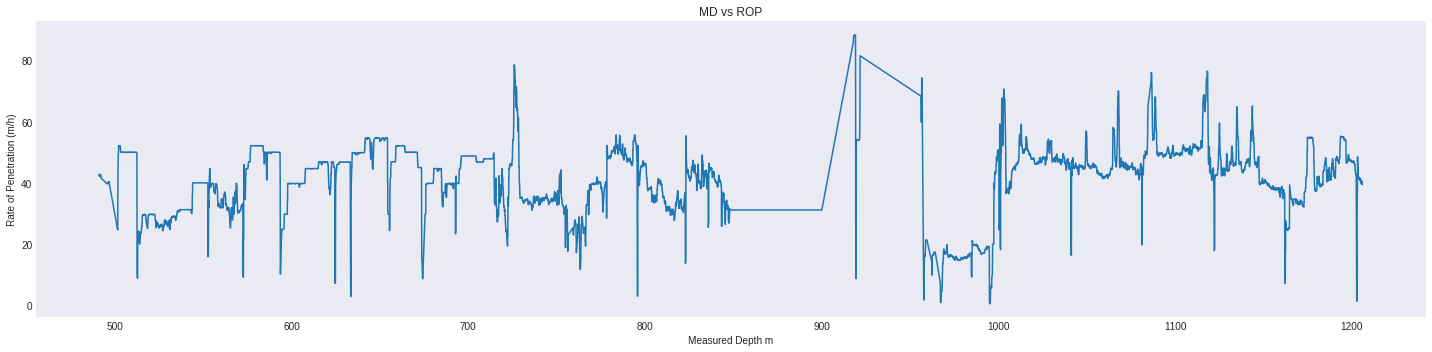

No handles with labels found to put in legend.


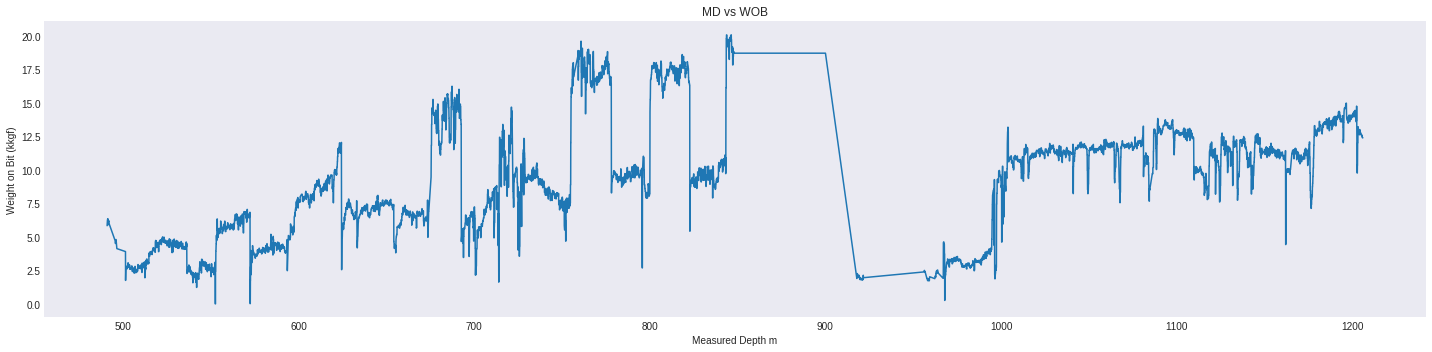

No handles with labels found to put in legend.


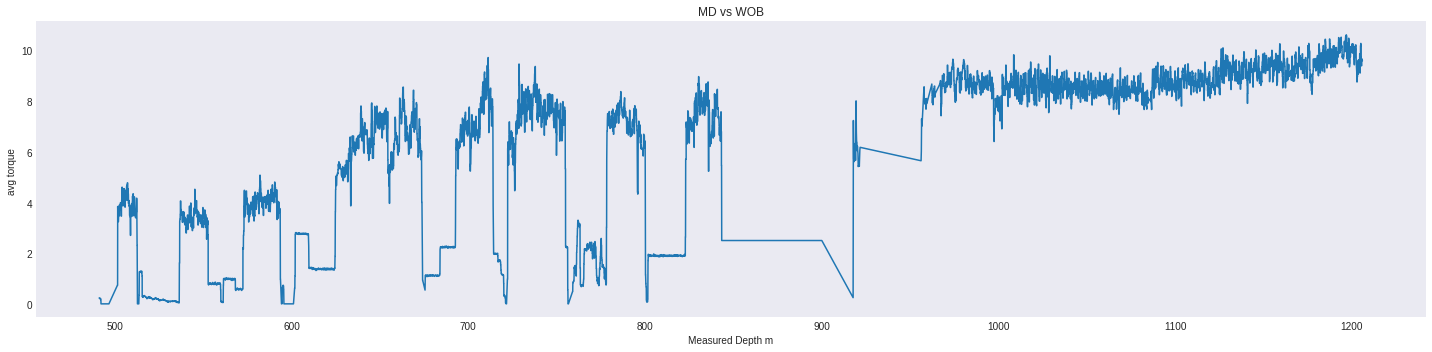

In [14]:
x = well1['Measured Depth m']
y = well1['Rate of Penetration m/h']
plt.figure(figsize=(20,5)) 
plt.plot(x,y)
plt.xlabel("Measured Depth m")
plt.ylabel("Rate of Penetration (m/h)")
plt.title("MD vs ROP")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
###
z = well1['Weight on Bit kkgf']
plt.figure(figsize=(20,5)) 
plt.plot(x,z)
plt.xlabel("Measured Depth m")
plt.ylabel("Weight on Bit (kkgf)")
plt.title("MD vs WOB")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

####
u = well1['Average Surface Torque kN.m']
plt.figure(figsize=(20,5)) 
plt.plot(x,u)
plt.xlabel("Measured Depth m")
plt.ylabel("avg torque ")
plt.title("MD vs WOB")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [15]:
## Zonation
## Bellow i used clustrering techniques on (ROP vs MD) to obtain diffrent formation zone.
## Per-zone estimation has been proved to be obatain good model.

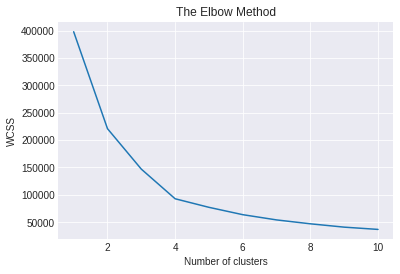

In [16]:
#K-mean                                                
# Measured Depth m VS Rate of Penetration m/h
X = well_train_norm.iloc[:, [0, -2]].values
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

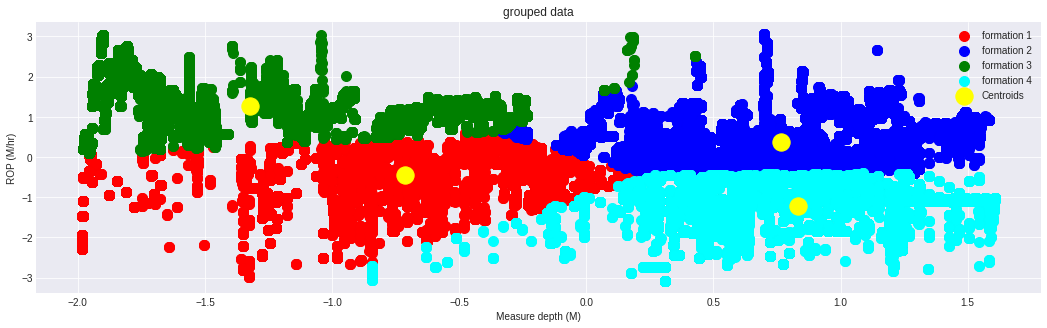

In [17]:
# From Elbow methods take K = 4(number of cluster)
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

plt.figure(figsize=(18,5))
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'formation 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'formation 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'formation 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'formation 4')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')

plt.title('grouped data')
plt.xlabel('Measure depth (M)')
plt.ylabel('ROP (M/hr)')

plt.legend()
plt.show()

In [18]:
### results of k-mean give us four diffrent formation 
## Formation 1 having Shallow Depth and Low ROP
## Formation 2 having Shallow Depth and High ROP
## Formation 3 having Deeper Depth and Low ROP
## Formation 4 having Deeper depth and High ROP

In [19]:
# Adding clustred value lies to each rows to separate the formation.
well_train_norm['Cluster'] = y_kmeans  
well_train_norm

Measured Depth m  Weight on Bit kkgf  ...  Hole Depth (TVD) m  Cluster
0              -1.764998            0.145520  ...          490.760309        2
1              -1.764870            0.246018  ...          490.910880        2
2              -1.764839            0.246018  ...          490.910880        2
3              -1.764741            0.277129  ...          491.061756        2
4              -1.764738            0.277129  ...          491.061756        2
...                  ...                 ...  ...                 ...      ...
198923         -1.643474            0.648300  ...          633.068076        2
198924         -1.643434            0.648300  ...          633.208589        2
198925         -1.643384            0.648300  ...          633.266196        2
198926         -1.643342            0.648300  ...          633.219562        2
198927         -1.643334            0.648300  ...          633.323803        2

[198928 rows x 13 columns]

In [20]:
formation_1 = well_train_norm[well_train_norm.Cluster == 0]    # Dataset for formation 1
formation_2 = well_train_norm[well_train_norm.Cluster == 1]    # Dataset for formation 2
formation_3 = well_train_norm[well_train_norm.Cluster == 2]    # Dataset for formation 3
formation_4 = well_train_norm[well_train_norm.Cluster == 3]    # Dataset for formation 4

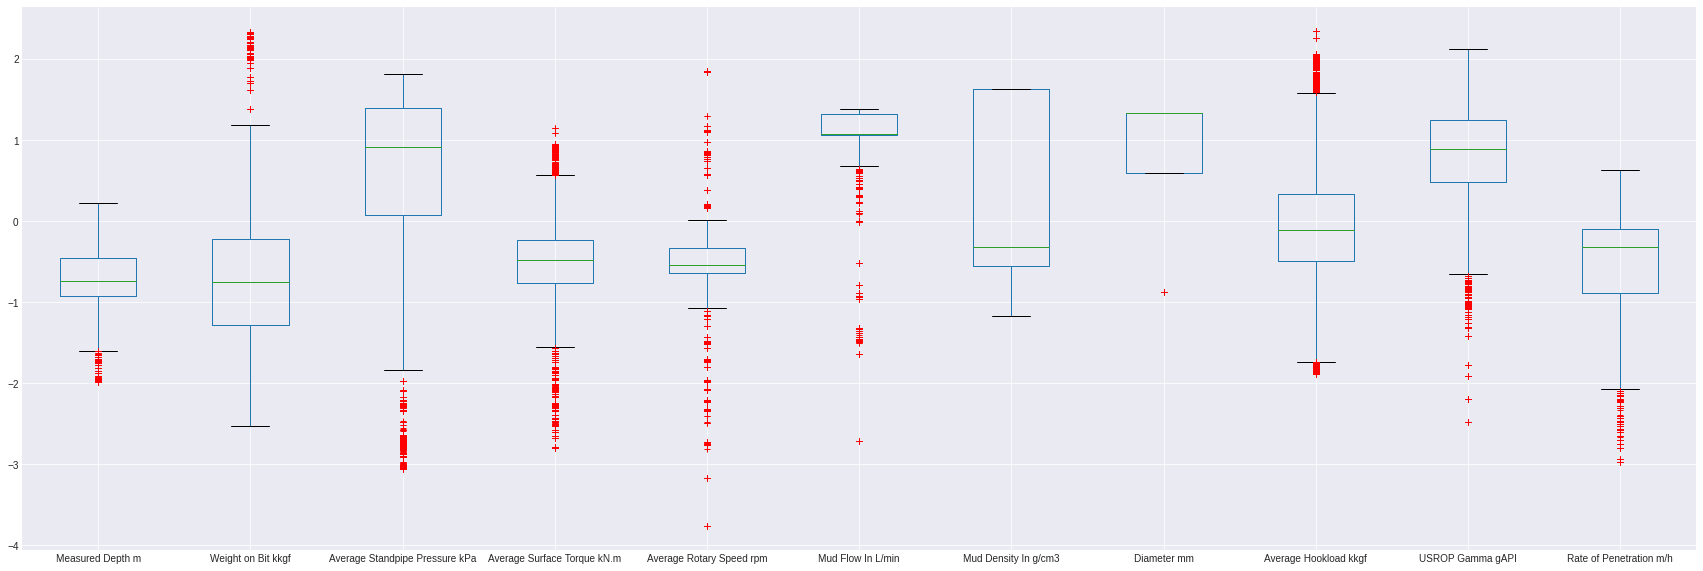

In [21]:
## Box-plot of formation_1, we can observe ROP and measure depth lies almost in same intervel
formation_1.drop(['Hole Depth (TVD) m','Cluster'],axis=1).plot.box(sym='r+', figsize=(30,10),fontsize=10)

In [22]:
formation_1.describe()

Measured Depth m  Weight on Bit kkgf  ...  Hole Depth (TVD) m  Cluster
count      50981.000000        50981.000000  ...        50981.000000  50981.0
mean          -0.713736           -0.742883  ...         1616.646379      0.0
std            0.391430            0.708792  ...          411.515270      0.0
min           -1.984397           -2.522535  ...          225.162770      0.0
25%           -0.919646           -1.277857  ...         1409.319000      0.0
50%           -0.735982           -0.749672  ...         1596.679560      0.0
75%           -0.460454           -0.222964  ...         1856.709961      0.0
max            0.223886            2.328913  ...         2510.471484      0.0

[8 rows x 13 columns]

In [23]:
# defining some functions for regression metrics and plot

def reg_metrics(test, pred):
    '''Function returns basic metrics for regression models'''
    print('Mean Absolute Error:', metrics.mean_absolute_error(test, pred))
    print('Mean Squared Error:', metrics.mean_squared_error(test, pred))
    print('Root Mean Squared Error:', np.sqrt(
        metrics.mean_squared_error(test, pred)))
    print('R Squared:', (metrics.r2_score(test, pred)))

def reg_plot(test, pred):
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('Regression Results')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.show()

In [24]:
## Model for formation_1
X = formation_1[feature]
y = formation_1[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('Shape of Training X:', X_train.shape)
print('Shape of Training y:', y_train.shape)
print('Shape of Test X:', X_test.shape)
print('Shape of Test y:', y_test.shape)

Shape of Training X: (38235, 10)
Shape of Training y: (38235,)
Shape of Test X: (12746, 10)
Shape of Test y: (12746,)


In [25]:
## Gradient Boosting Regressor including Hyperparameters tuning

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

y_pred1 = model.predict(X_test)

# Metrics for GradientBoosting
reg_metrics(y_test, y_pred1)

Mean Absolute Error: 0.17878367572741533
Mean Squared Error: 0.06754611939093211
Root Mean Squared Error: 0.25989636278896266
R Squared: 0.8150073865341856


In [26]:
## Hyperparameters tuning For Gradient Boosting
from sklearn.model_selection import GridSearchCV

model = GradientBoostingRegressor()

## Hyperparameters
max_depth = [10, 100]
# max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 4]
min_samples_split = [2, 10]
n_estimators = [100, 1000]

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth}

## Randomized CV
model_random = GridSearchCV(model, param_grid, cv=3)
model_random.fit(X_train, y_train)

## print best model
model_random.best_params_

# metric MEA
y_pred_formation_1 = model_random.predict(X_test)
reg_metrics(y_test, y_pred_formation_1)

Mean Absolute Error: 0.0053161429629584355
Mean Squared Error: 0.001864831669045072
Root Mean Squared Error: 0.04318369679688241
R Squared: 0.9948926735208303


In [27]:
## same Model for formation_2
X = formation_2[feature]
y = formation_2[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('Shape of Training X:', X_train.shape)
print('Shape of Training y:', y_train.shape)
print('Shape of Test X:', X_test.shape)
print('Shape of Test y:', y_test.shape)

Shape of Training X: (50747, 10)
Shape of Training y: (50747,)
Shape of Test X: (16916, 10)
Shape of Test y: (16916,)


In [28]:
## Gradient Boosting Regressor

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

y_pred2 = model.predict(X_test)

# Metrics for GradientBoosting
reg_metrics(y_test, y_pred2)

Mean Absolute Error: 0.17630811681092157
Mean Squared Error: 0.06171225047497472
Root Mean Squared Error: 0.24841950502119337
R Squared: 0.7607731745959936


In [29]:
## Hyperparameters tuning For Gradient Boosting
from sklearn.model_selection import GridSearchCV

model = GradientBoostingRegressor()

## Hyperparameters
max_depth = [10, 100]
# max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 4]
min_samples_split = [2, 10]
n_estimators = [100, 1000]

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth}

## Randomized CV
model_random = GridSearchCV(model, param_grid, cv=3)
model_random.fit(X_train, y_train)

## print best model
model_random.best_params_

# metric MEA
y_pred_formation_2 = model_random.predict(X_test)
reg_metrics(y_test, y_pred_formation_2)

Mean Absolute Error: 0.0046497642986249145
Mean Squared Error: 0.0007968060454359165
Root Mean Squared Error: 0.028227753106400737
R Squared: 0.9969111905781227


In [30]:
## Model for formation_3
X = formation_3[feature]
y = formation_3[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('Shape of Training X:', X_train.shape)
print('Shape of Training y:', y_train.shape)
print('Shape of Test X:', X_test.shape)
print('Shape of Test y:', y_test.shape)

Shape of Training X: (28721, 10)
Shape of Training y: (28721,)
Shape of Test X: (9574, 10)
Shape of Test y: (9574,)


In [31]:
## Gradient Boosting Regressor

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

y_pred3 = model.predict(X_test)

# Metrics for GradientBoosting
reg_metrics(y_test, y_pred3)

Mean Absolute Error: 0.1314803522672185
Mean Squared Error: 0.030790507891460695
Root Mean Squared Error: 0.1754722425099215
R Squared: 0.8852342027293589


In [32]:
## Hyperparameters tuning For Gradient Boosting
from sklearn.model_selection import GridSearchCV

model = GradientBoostingRegressor()

## Hyperparameters
max_depth = [10, 100]
# max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 4]
min_samples_split = [2, 10]
n_estimators = [100, 1000]

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth}

## Randomized CV
model_random = GridSearchCV(model, param_grid, cv=3)
model_random.fit(X_train, y_train)

## print best model
print(model_random.best_params_)

# metric MEA
y_pred_formation_3 = model_random.predict(X_test)
reg_metrics(y_test,y_pred_formation_3)

{'max_depth': 10, 'n_estimators': 1000}
Mean Absolute Error: 0.003486279562376363
Mean Squared Error: 0.001271370799376346
Root Mean Squared Error: 0.035656286954425666
R Squared: 0.9952612056958793


In [33]:
## Model for formation_3
X = formation_3[feature]
y = formation_3[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('Shape of Training X:', X_train.shape)
print('Shape of Training y:', y_train.shape)
print('Shape of Test X:', X_test.shape)
print('Shape of Test y:', y_test.shape)

Shape of Training X: (28721, 10)
Shape of Training y: (28721,)
Shape of Test X: (9574, 10)
Shape of Test y: (9574,)


In [34]:
## Gradient Boosting Regressor

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

y_pred4 = model.predict(X_test)

# Metrics for GradientBoosting
reg_metrics(y_test, y_pred4)

Mean Absolute Error: 0.1314807366327989
Mean Squared Error: 0.030793602985092934
Root Mean Squared Error: 0.175481061613762
R Squared: 0.8852226663529671


In [35]:
## Hyperparameters tuning For Gradient Boosting
from sklearn.model_selection import GridSearchCV

model = GradientBoostingRegressor()

## Hyperparameters
max_depth = [10, 100]
# max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 4]
min_samples_split = [2, 10]
n_estimators = [100, 1000]

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth}

## Randomized CV
model_random = GridSearchCV(model, param_grid, cv=3)
model_random.fit(X_train, y_train)

## print best model
print(model_random.best_params_)

# metric MEA
y_pred_formation_4 = model_random.predict(X_test)
reg_metrics(y_test,y_pred_formation_4)

{'max_depth': 10, 'n_estimators': 1000}
Mean Absolute Error: 0.003441718179768083
Mean Squared Error: 0.0012631920072414483
Root Mean Squared Error: 0.03554141256677129
R Squared: 0.9952916905973749


In [36]:
result_data = {'models' : ['formation_1','formation_2','formation_3','formation_4'],
                    "MEA"  :[0.0019152702604260795,0.0008104220010888268,0.003491993089510495,0.003460630866156586],
                'R_squared':[0.9947545343216692,0.9968584084834718,0.99539047850675,0.9954688149331613]}

result_data_df = pd.DataFrame(result_data)
print(result_data_df)
print('The average MEA of all formation model are: {}'.format(result_data_df['MEA'].mean()))


        models       MEA  R_squared
0  formation_1  0.001915   0.994755
1  formation_2  0.000810   0.996858
2  formation_3  0.003492   0.995390
3  formation_4  0.003461   0.995469
The average MEA of all formation model are: 0.0024195790542954967


In [37]:
X = well_train_norm[feature]
y = well_train_norm[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('Shape of Training X:', X_train.shape)
print('Shape of Training y:', y_train.shape)
print('Shape of Test X:', X_test.shape)
print('Shape of Test y:', y_test.shape)

Shape of Training X: (149196, 10)
Shape of Training y: (149196,)
Shape of Test X: (49732, 10)
Shape of Test y: (49732,)


In [38]:
## Gradient Boosting Regressor

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

y_pred_xgb = model.predict(X_test)

# Metrics for GradientBoosting
reg_metrics(y_test, y_pred_xgb)


Mean Absolute Error: 0.33407938139323007
Mean Squared Error: 0.21716098638385403
Root Mean Squared Error: 0.46600535016655553
R Squared: 0.7827872348284457


In [39]:
## Hyperparameters tuning For Gradient Boosting
from sklearn.model_selection import GridSearchCV

model1 = GradientBoostingRegressor()

## Hyperparameters
max_depth = [10, 100]
# max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 4]
min_samples_split = [2, 10]
n_estimators = [100, 1000]

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth}

## Randomized CV
model_random1 = GridSearchCV(model1, param_grid, cv=3)
model_random1.fit(X_train, y_train)

## print best model
model_random1.best_params_

# metric result
y_pred = model_random1.predict(X_test)
reg_metrics(y_test,y_pred)

Mean Absolute Error: 0.01338248716967663
Mean Squared Error: 0.0023481264584615225
Root Mean Squared Error: 0.048457470615597784
R Squared: 0.9976513136659209


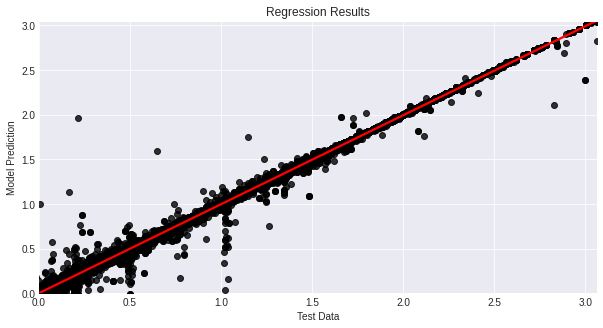

In [40]:
plt.figure(figsize=(10,5))
reg_plot(y_test,y_pred)

# 5.Final Prediction and Submission

In [41]:
## Loading and normalize test data
test_df.describe()

Measured Depth m  ...  USROP Gamma gAPI
count     114299.000000  ...     114299.000000
mean        3282.064976  ...         37.111566
std          892.118219  ...         49.309222
min          365.150000  ...          0.000000
25%         2899.651000  ...          4.746000
50%         3492.121000  ...          8.173000
75%         3781.202500  ...         53.410000
max         5310.988000  ...        470.460000

[8 rows x 11 columns]

In [42]:
well_names = test_df['Well Identifier'].unique()
well_names

array(['TC-2021-TW'], dtype=object)

In [43]:
## prediction of test data using Hyperparameters tuning

well_test_norm = scaler.fit_transform(well_test_drop)   ##well_test_drop from cell 32

# Predict to well 'TC-2021-TW'

rop_pred =  model_random1.predict(well_test_norm)

# Denormalize y_pred of well 1
# make the transformer fit to the target

y = well_train[target].values
scaler.fit(y.reshape(-1,1))

rop_pred = scaler.inverse_transform(rop_pred.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [44]:
column = ['Rate of Penetration m/h']
rop_offset = pd.DataFrame(rop_pred, columns = column)
rop_offset

Rate of Penetration m/h
0                     16.030154
1                     16.030154
2                     16.030154
3                     16.030154
4                     16.030154
...                         ...
114294                -0.304138
114295                -0.304138
114296                -0.028011
114297                -0.028011
114298                -0.028011

[114299 rows x 1 columns]

In [45]:
rop_offset.to_csv('/content/sample_data.csv', index=False)

# 6.Summary

We got the pre processed therefore we wont find any missing values.However the data processing takes 50 percent
of the time to build model.

Zonation and diffrent machine learning model improve the performance of our model. 

Domine knowledge of drilling is essential for the successful application of machine learning techniques to ROP prediction.
> 
Reference:
1. Drilling performance monitoring and optimization: a data-driven approach (doi.org/10.1007/s13202-019-0657-2)
2. A New Model for Predicting Rate of Penetration Using an Artificial Neural Network (doi:10.3390/s20072058)
3. Drilling Efficiency Improvement and ROP by Machine Learning and Data Analytics(doi.org/10.33889/IJMEMS.2020.5.3.032)